#Project Deep learning Team06:##
  BEAURAIN Vincent \
  LISUMBU Joël \
  PRADELS Léo Muriel \
  RANNOU Nicolas Jean

#Exercise 1: Convolutional Autoencoder#


Here we import all the libraries we will need.

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import copy
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
from IPython.display import display
from PIL import Image
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import matplotlib.pyplot as plt
import pandas as pd

Let's define some hyper-parameters for the train and the model. We select to work on GPU if it is available in the machine, otherwise we will run on the CPU.


In [0]:
hparams = {
    'batch_size':64,
    'num_epochs':5,
    'test_batch_size':256,
    'hidden_size':128,
    'learning_rate':1e-3,
    'log_interval':100,
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

##Exercice 1.1: Load Dataset
We load the dataset from the MNIST dataset and we normalize it. 

In [3]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))                        
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

0it [00:00, ?it/s]

9920512it [00:06, 1611770.70it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 128167.93it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2128708.60it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 49439.68it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


**Split data**: \
We split the dataset in 95% for training and 5% for validation. \
To do that we take the size of the trainset and after that we take 5% of dataset. We split the dataset



In [4]:
tvdataset_length = len(mnist_trainset)
validationset_length = int(0.05*tvdataset_length)
[trainset,validationset]=torch.utils.data.random_split(mnist_trainset,[tvdataset_length-validationset_length,validationset_length])
print('Validation dataset is {}% of the total length of the dataset.'.format(100*len(validationset)/len(mnist_trainset)))
print('Training dataset is {}% of the total length of the dataset.'.format(100*len(trainset)/len(mnist_trainset)))

Validation dataset is 5.0% of the total length of the dataset.
Training dataset is 95.0% of the total length of the dataset.


**Loader data**
We load the dataset with batch size 

In [0]:
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validationset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

## Exercice 1.2: Implement a convolutional autoencoder (with separate Encoder and Decoder modules). ##

**Definition of the Class Encoder** \
This class have 4 layers: 2 convolutional layers and 2 linears layers. \
The constructor of the class take as input the size of the bottleneck. \
The input size is (1x28x28) \
The first convolutional layer has a output of size (8x14x14). \
The second convolutional layer has a output of size (16x5x5). \
The two linear layers have respectly outputs of sizes (1x180) and (1x bottleneck size).

In [0]:
class Encoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
              nn.Conv2d(1,8,3,padding=1),
              nn.BatchNorm2d(8),
              nn.ReLU(inplace = True),
              nn.MaxPool2d(2),
              nn.Dropout(0.2))
    self.conv2 = nn.Sequential(
              nn.Conv2d(8,16,5),
              nn.BatchNorm2d(16),
              nn.ReLU(inplace = True),
              nn.MaxPool2d(2),
              nn.Dropout(0.2)
              )
    self.fc = nn.Sequential(
              nn.Linear(5*5*16,180),
              nn.BatchNorm1d(180),
              nn.ReLU(),
              nn.Linear(180,self.bottleneck),
              nn.BatchNorm1d(self.bottleneck),
              nn.ReLU())
  def forward(self,x):
    x= self.conv1(x)
    x= self.conv2(x)
    x= self.fc(x.view(-1,5*5*16))
    return x  

**Definition of the Class Decoder** \
This class have 4 layers: 2 convolutional layers and 2 linears layers. \
The constructor of the class take as input the size of the bottleneck. \
The input size is (1x bottleneck size) \
The two linear layers have respectly outputs of size (1x180) and (1x400).\
The first convolutional layer has a output of size (8x14x14). \
The second convolutional layer has a output of size (1x28x28). \

In [0]:
class Decoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
          nn.UpsamplingBilinear2d(scale_factor = 2),
          nn.ConvTranspose2d(16,8,5),
          nn.BatchNorm2d(8),
          nn.ReLU(),
          nn.Dropout(0.2)
          )
    self.conv2 = nn.Sequential(
          nn.UpsamplingBilinear2d(scale_factor = 2),
          nn.ConvTranspose2d(8,1,3,padding=1),
          nn.BatchNorm2d(1),
          nn.Tanh(),
          nn.Dropout(0.2)
          )
    self.fc = nn.Sequential(
          nn.Linear(self.bottleneck,180),
          nn.BatchNorm1d(180),
          nn.ReLU(),
          nn.Linear(180,5*5*16),
          nn.BatchNorm1d(5*5*16),
          nn.ReLU()
          )
  def forward(self,x):
    x= self.fc(x)
    x= self.conv1(x.view(-1, 16, 5,5))
    x= self.conv2(x)
    return x

**Definition of the class Autoencoder** \
We define the AutoEncoder class that has 2 sets of layers: the first one is the Encoder and the second one is the Decoder.

In [0]:
class Autoencoder(nn.Module):
    def __init__(self,bottleneck):
      super().__init__()
      self.bottleneck = bottleneck
      self.encoder = Encoder(self.bottleneck)
      self.decoder = Decoder(self.bottleneck)
    def forward(self,x):
      x= self.encoder(x)
      x= self.decoder(x)
      return x

## Exercice 1.3 & 1.4: Train the convolutional Autoencoder & Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets

Definition of the function *train epoch*. \
First we set the model on *training mode*.\
It train the weights of the model. It computes the loss of the train and it performs the backpropagation. \
It returns a list which contains all the losses from the batch of the train.

In [0]:
def train_epoch(train_loader,model,optimizer,criterion):
  model.train()
  losses = []
  for batch_idx, data in enumerate(train_loader):
          optimizer.zero_grad()
          img, _ = data
          img = img.cuda()
          output = model(img)
          loss = criterion(output,img)
          loss.backward()
          optimizer.step()
          losses.append(loss.item())
  return losses

It is a generic fonction to evaluate the model. \
Now we set the model on *evaluation mode*.\
It returns the average MSE. \

In [0]:
def test_epoch(set_loader,model):
  model.eval()
  MSE = 0
  with torch.no_grad():
    for data in set_loader:
      img,_ = data
      img = img.cuda()
      output = model(img)
      MSE += criterion(output,img)
  MSE /= len(set_loader) 
  return MSE

Function to compute the number of parameters

In [0]:
def number_param(model):
  return sum(p.numel() for p in model.parameters())

###Train of the model and evalutation of it with different bottleneck 
For each size of bottleneck [5,9,13,17,21], we store the model in a dictionnary with as a key the size of the bottleneck and for value the correspondant model.\
We initialize the different lists that will contain the loss and we initialize the loss function and the optimizer we will use.\
We compute the backpropagation for each epoch.\
Finally we compute the average MSE for the test loader.\
We store all the loss and MSE in order to plot it later.

In [0]:
dic_MSE = dict()
validation_loss_bottleneck = dict()
train_loss_bottleneck = dict()
models = dict()

for bottleneck in range(5,25,4):

    model = Autoencoder(bottleneck).cuda()
    model.to(hparams['device'])
    models[bottleneck] = model
    number_param_bottleneck = number_param(model)
    
    list_MSE_validation = []
    train_loss = []
    criterion = nn.MSELoss()
    optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])

    for epoch in range(hparams['num_epochs']):
      
      train_loss.extend(train_epoch(train_loader,model,optimizer,criterion))
      list_MSE_validation.append(test_epoch(validation_loader,model))

    test_MSE = test_epoch(test_loader,model)
    train_loss_bottleneck[bottleneck]= train_loss
    validation_loss_bottleneck[bottleneck] = list_MSE_validation
    dic_MSE[bottleneck]= [test_MSE.item(),list_MSE_validation[-1].item(),number_param_bottleneck]

Plot the Loss 
We rescale both lists in order to plot it on the same graph.\
We display the 5 different bottleneck size with 5 different colors.\
The trainset are represented wit '-' and the validation with 'o'.

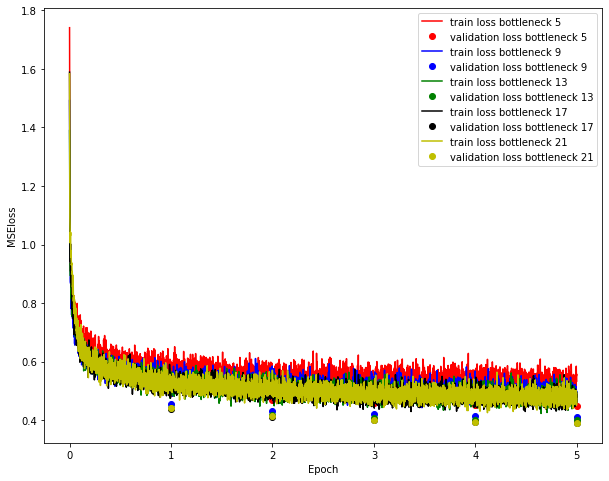

In [15]:
fig = plt.subplots(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
form = ['-','o']
color = ['r','b','g','k','y']
i=0
for bottleneck in train_loss_bottleneck.keys():
   plt.plot(np.arange(0,
            len(train_loss_bottleneck.get(bottleneck)),
            step=1),
            train_loss_bottleneck.get(bottleneck),
            color[i]+form[0], 
            label='train loss bottleneck {}'.format(bottleneck))
   plt.plot(np.arange(len(train_loss_bottleneck.get(bottleneck))/(hparams['num_epochs']),
            len(train_loss_bottleneck.get(bottleneck))+len(train_loss_bottleneck.get(bottleneck))/(hparams['num_epochs']),
            step=len(train_loss_bottleneck.get(bottleneck))/(hparams['num_epochs'])),
            validation_loss_bottleneck.get(bottleneck),
            color[i]+form[1],
            label='validation loss bottleneck {}'.format(bottleneck))
   plt.xticks(np.arange(0,
            len(train_loss_bottleneck.get(bottleneck))+len(train_loss_bottleneck.get(bottleneck))/(hparams['num_epochs']),
            step=len(train_loss_bottleneck.get(bottleneck))/(hparams['num_epochs'])),
            [i for i in range(hparams['num_epochs']+1)])
   i+=1
plt.legend()
plt.show()

**Table of the differents MSE** \
We display with Pandas the table of the MSE and the number of parameters of the model for the different size of bottleneck.

In [45]:
data = {"Bottleneck":["Test MSE","Validation MSE","number of parameters"]}
data.update(dic_MSE)
df = pd.DataFrame(data)
df = df.groupby('Bottleneck')
df.first()

,5,9,13,17,21
Bottleneck,,,,,
Test MSE,0.460018,0.421387,0.408430,0.399923,0.400153
Validation MSE,0.448010,0.411489,0.398984,0.390428,0.390298
number of parameters,154738.000000,156190.000000,157642.000000,159094.000000,160546.000000


## Exercice 1.5: Select one of the autoencoders and feed it 5 random MNIST images from the test set. 
We take the model for a bottleneck of size 17

In [0]:
bottleneck = 17
model = models[bottleneck]


We display 5 random images and the ouput of the model

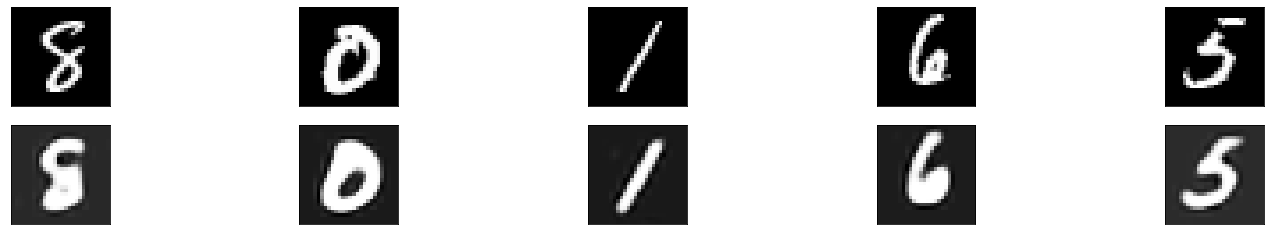

In [18]:
random_set_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=5, 
    shuffle=True)
dataiter = iter(random_set_loader)
images,_ =dataiter.next()
images = images.cuda()
model.eval()
output = model(images)
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4
))  
for images, row in zip([images, output],axes):
  for img,ax in zip(images,row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Exercice 1.6: Generate 5 new images by injecting random values as input to the decoder.
We generate 5 new images with some random values.

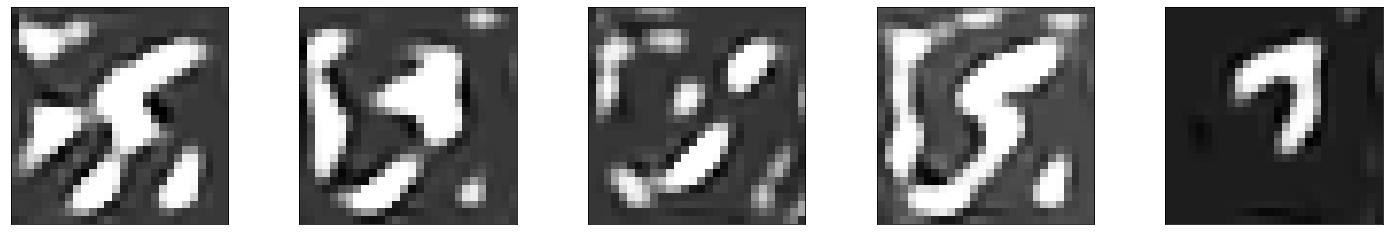

In [19]:
nb_images = 5
rand_features = torch.randn(nb_images, bottleneck).to(hparams['device']) 
output = model.decoder(rand_features)
output = output.cpu().detach().numpy()
images_width = 28
fig, axes = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True,figsize=(25,4))
decoded_images = output[:nb_images]  
for ax, img in zip(axes, decoded_images):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice 2: Transfer Learning


#Exercice 2.1: Select a subset of 100 images and their associated labels from the MNIST training data.
We take a subset of 100 images and their associates label from the MNIST training data.

In [0]:
nb_images_subnet = 100
batch_size_20 = 20
[trainset,_]=torch.utils.data.random_split(mnist_trainset,[nb_images_subnet,tvdataset_length-nb_images_subnet])
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size_20, 
    shuffle=True)

#Exercice 2.2: Select one of the previously trained autoencoders.
We first take the layers of the encoder part of the  model autoencoder. We take the one with a bottleneck of length 17.

In [21]:
encoder_pretrain = copy.deepcopy(model.encoder)
encoder_pretrain.eval()
encoder_pretrain.to(hparams['device'])

Encoder(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=180, bias=True)
    (1): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=180, out_features=17, bias=True)
    (4): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_s

#Exercice 2.3: Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
We create the classification model. We just add to the encoder layer a fully connected projetction layer that will do the classification of the numbers.

In [0]:
bottleneck = 17
class Classification(nn.Module):
  def __init__(self,endoder):
    super().__init__()
    self.layers = endoder
    self.fc = nn.Sequential(
        nn.Linear(bottleneck,150),
        nn.ReLU(),
        nn.Linear(150,10),
        nn.LogSoftmax(dim=1)
    )
  def forward(self,x):
    x = self.layers(x)
    x= self.fc(x)
    return x

#Exercice 2.4: Pre-training
Definition of the training and testing epoch, using the previous weights.

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) 
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
  return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            acc += correct_predictions(output, target)
    test_acc = 100. * acc / len(test_loader.dataset)
    return test_acc

Definition of the epoch function

In [0]:
hparams['num_epochs'] = 80

def epoch(model_,optimizer_):  
    te_accs = []
    model_.to(hparams['device'])
    optimizer = optimizer_ 
    criterion = F.nll_loss

    for epoch in range(1, hparams['num_epochs']):
      train_epoch(train_loader, model_, optimizer, criterion, hparams)
      te_accs.append(test_epoch(test_loader, model_, hparams))   
    return te_accs

We define the network and we train it.

In [0]:
model_classifier = Classification(encoder_pretrain)
optimzer_pretrain = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
accs_pretrain=epoch(model_classifier,optimzer_pretrain)

#Exercice 2.5: Fine-tunning
We use *optim.SGD* in order to have 2 learning rates: a low one for the training and a normal one

In [0]:
fine_tuning_features = copy.deepcopy(model.encoder)
fine_tuning_model= Classification(fine_tuning_features)
optimzer_fine_tuning = optim.SGD([
                {'params': fine_tuning_model.layers.parameters()},
                {'params': fine_tuning_model.fc.parameters(), 'lr':hparams['learning_rate'] }
            ], lr=1e-6, momentum=0.9)

Train the model with the fine-tuning lerning rate

In [0]:
acc_fine_tuning =epoch(fine_tuning_model,optimzer_fine_tuning)

#Exercice 2.6: Train the model from scratch

Model Train from scratch

In [0]:
bottleneck = 17
network_scratch = Classification(Encoder(17))
optimzer_scratch = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
accs_scratch = epoch(network_scratch,optimzer_scratch)

#Exercice 2.7: Show the accuracy of the three models on the MNIST test set in a table.

In [52]:
data = {'Accuracy Train model %':accs_pretrain,'Accuracy model Fine-tuning %':acc_fine_tuning,'Accuracy Model from scratch %':accs_scratch}
df = pd.DataFrame(data)
print(df.to_string(index=False))

 Accuracy Train model %  Accuracy model Fine-tuning %  Accuracy Model from scratch %
                  54.26                          5.54                          10.28
                  61.23                          6.63                          10.28
                  71.15                          8.13                          10.25
                  74.39                          9.81                           9.97
                  75.91                         11.77                           9.86
                  80.57                         12.62                           9.62
                  80.70                         13.35                           9.31
                  81.39                         16.70                           9.21
                  82.51                         21.23                           9.02
                  82.74                         23.70                           8.58
                  83.30                         25.67            

#Exercice A: Variational Autoencoder

#Exercice A.1: Implement an autoencoder
We take the size of the trainset and after we split the dataset.

In [30]:
tvdataset_length = len(mnist_trainset)
validationset_length = int(0.05*tvdataset_length)
[trainset,validationset]=torch.utils.data.random_split(mnist_trainset,[tvdataset_length-validationset_length,validationset_length])
print('Validation dataset is :{}%'.format(100*len(validationset)/len(mnist_trainset)))
print('Training dataset is :{}%'.format(100*len(trainset)/len(mnist_trainset)))

Validation dataset is :5.0%
Training dataset is :95.0%


In [0]:
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validationset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

Definition of the class VariationalAutoencoder: \
We create the normal distribution N(0,1) with the same size of sigma and as a Float tensor. \
We take the 20th first parameters for the mean. \
From 20 to the end we take the the ln (log) of the variance. \

In [0]:
class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.bottleneck = 40
    self.encoder = Encoder(self.bottleneck)
    self.decoder = Decoder(20)
  def reparametrize(self,mu,logvar):
    var = logvar.exp()
    sigma = var.sqrt()

    normal = Variable(torch.cuda.FloatTensor(sigma.size()).normal_())
    return normal.mul(sigma).add(mu)
  def forward(self,x):
    x=self.encoder(x)

    mu = x[:,:20]

    logvar = x[:,20:]
    x= self.reparametrize(mu,logvar)
    x = self.decoder(x)
    return x,mu,logvar

#Exercice A.2:Train the model optimizing the Evidence Lower Bound (ELBO)
For the forward, we add the KullBack Leigler divergence wich compute the differences between 2 distributions of probability. \

In [0]:
model = VariationalAutoencoder().cuda()
criterion = nn.MSELoss()
optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])
for epoch in range(hparams['num_epochs']):
    for data in train_loader:
        model.train()     
        img, _ = data
        img,_ = data
        img = img.cuda()

        x_hat, mu, logvar = model(img)
        NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
        KLD = torch.sum(NKLD).mul(-0.5)
        KLD /= 128 * 784
        loss = criterion(x_hat, img) + KLD

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

We take 5 random images

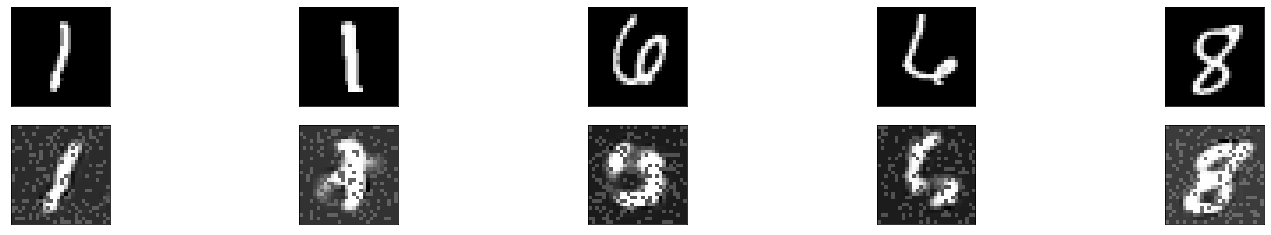

In [34]:
random_set_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=5, 
    shuffle=True)
dataiter = iter(random_set_loader)
images,_ =dataiter.next()
images = images.cuda()
output,_,_ = model(images)
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4
))  
for images, row in zip([images, output],axes):
  for img,ax in zip(images,row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice A.3: Generate samples with the decoder and show them

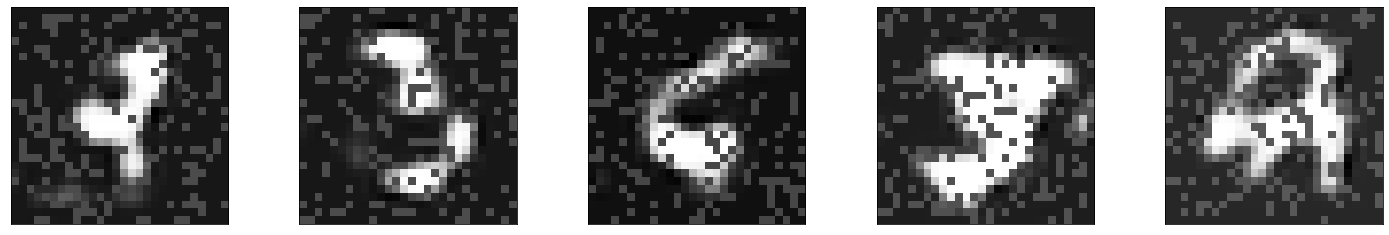

In [35]:
nb_images = 5
bottleneck = 20
rand_features = torch.randn(nb_images, bottleneck).to(hparams['device']) 
output = model.decoder(rand_features)
output = output.cpu().detach().numpy()
images_width = 28
fig, axes = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True,figsize=(25,4))
decoded_images = output[:nb_images]  
for ax, img in zip(axes, decoded_images):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice B: Conditional GAN
#Exercice B.1: Implement a generator and discriminator based con deconvolutions and convolutions respectively

Here is two funtions the first one returns some normal noize and the second one is here to init the weight of the model

In [0]:
hparams['batch_size'] = 100
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validationset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

We define *norm_noise* which creates a number of *size* gaussian noises of length 100 which, *init_weights* which initializes the weights of the model, *display_batch_images* print the images.

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size,100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('layers') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):

    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    img = img.cpu().float()
    img = (img*std+mean)*255

    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

Class Generator based on the decoder

In [0]:
class Generator(torch.nn.Module):
  def __init__(self,bottleneck=100):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
          nn.ConvTranspose2d(1024,512,5,stride=1,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Dropout(0.2)
          )
    self.conv2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor = 2),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
    self.conv3 = nn.Sequential(
          nn.UpsamplingBilinear2d(scale_factor = 2),
          nn.ConvTranspose2d(256,1, kernel_size=5, stride=1, padding=2),
          nn.Tanh()
          )
    self.fc = nn.Linear(self.bottleneck,1024*5*5)
  def forward(self,x):
    x= self.fc(x)
    x= self.conv1(x.view(-1, 1024, 5,5))
    x= self.conv2(x)
    x= self.conv3(x)
    return x

Definition class Discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        #32x32
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4))

The first step of the initialization is to prepare the model. \
In *create_network* we create a network with a discriminator and a generator, then we initialize the weights and then we move to cuda().\
In *create_optimizer* we set the generator and discriminator optimizer.\
In *_init_criterion* we create variables we will use as target for the training of the model. One will be for fake images and the other for true images. \
Then we use the generator which will create the fake samples.\
In *step_optimization* we compute the losses of the generator and discriminator. \
In *_step_opt_g* we compute the loss of the generator. \
In *_step_opt_d* we compute the loss of the discriminator. \

In [0]:
class Model:
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):

        self._generator = Generator()
        self._discriminator = Discriminator()
        
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()      
    
    def generate_samples(self, batch_size, z=None):
        if z is None:
            z = norm_noise(batch_size)
        fake_samples = self._generator(z)
        return fake_samples
        
    def step_optimization(self, real_samples):
        fake_samples = self.generate_samples(real_samples.size(0))
        loss_g = self._step_opt_g(fake_samples)
        loss_d = self._step_opt_d(real_samples, fake_samples.detach())
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples):
        self._opt_g.zero_grad()
        estim_fake =  self._discriminator(fake_samples)
        loss = self._criterion(estim_fake,self._label_real)
        loss.backward()
        self._opt_g.step()
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples):
        self._opt_d.zero_grad()
        estim_real =self._discriminator(real_samples)
        loss_real = self._criterion(estim_real,self._label_real)
        estim_fake =  self._discriminator(fake_samples)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self._opt_d.step()
        return loss_real.item(), loss_fake.item()

#Exercice B.2: train the GAN on MNIST

In [0]:
num_epochs = 10
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(hparams['batch_size'])

We train the model

In [0]:
for epoch in range(num_epochs):
    for n_batch, (real_samples,_) in enumerate(train_loader):
        real_samples = Variable(real_samples).cuda()
        loss_g, loss_d = model.step_optimization(real_samples)

#Exercice B.3: Generate samples with the generator and show them

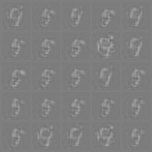

In [111]:
val_fake_samples = model.generate_samples(num_val_samples, z=z_val).data.cpu()
display_batch_images(val_fake_samples)